<a href="https://colab.research.google.com/github/Fenny-057/E-WasteGeneration-Classification/blob/main/E_waste_generation_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-Waste Classification with Image and Metadata

This notebook demonstrates building a deep learning model that classifies e-waste items using both image data and associated metadata (like weight, voltage, portability, and material score). This approach can potentially improve classification accuracy by leveraging multiple data sources.

## 1. Setting up the Environment and Loading Data

First, we import the necessary libraries for building and deploying our model, and then we load and prepare our dataset.

In [1]:
import tensorflow as tf

from tensorflow.keras import layers, models,Input,Model

from tensorflow.keras.applications import EfficientNetV2B0

from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras.preprocessing import image

import numpy as np

import matplotlib.pyplot as plt

import cv2

import gradio as gr

from PIL import Image

In [2]:
!unzip /content/archive.zip -d /content/extracted_data

Archive:  /content/archive.zip
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_106.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_128.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_148.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_152.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_174.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_177.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_190.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_192.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_211.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_22.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_24.jpg  
  inflating: /content/extracted_data

In [3]:
trainpath = r'/content/extracted_data/modified-dataset/train'
testpath = r'/content/extracted_data/modified-dataset/test'
validpath = r'/content/extracted_data/modified-dataset/val'

## 2. Data Preprocessing and Exploration

Before training, we preprocess the image and metadata, and explore the class distribution in our dataset.

In [4]:
img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    trainpath,
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validpath,
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    testpath,
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)


Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [5]:
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for batch in dataset:
        imgs, lbls = batch
        images.append(imgs.numpy())
        labels.append(lbls.numpy())
    return np.concatenate(images), np.concatenate(labels)

X_train, y_train = dataset_to_numpy(train_ds)
X_val, y_val = dataset_to_numpy(val_ds)
X_test, y_test = dataset_to_numpy(test_ds)


In [6]:
def generate_metadata(num_samples):
    weight = np.random.uniform(0.1, 5.0, size=(num_samples, 1))
    voltage = np.random.uniform(1.5, 220, size=(num_samples, 1))
    is_portable = np.random.randint(0, 2, size=(num_samples, 1))
    material_score = np.random.uniform(0, 1, size=(num_samples, 1))
    return np.concatenate([weight, voltage, is_portable, material_score], axis=1)


In [7]:
train_meta = generate_metadata(2400)
val_meta = generate_metadata(300)
test_meta = generate_metadata(300)


In [8]:
class_names = train_ds.class_names

def plot_class_distribution(dataset, title="Class Distribution"):


    class_counts = {}

    for images, labels in dataset:

        for label in labels.numpy():
            class_name = dataset.class_names[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1


    class_names = list(class_counts.keys())
    counts = list(class_counts.values())


    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Number of Items")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

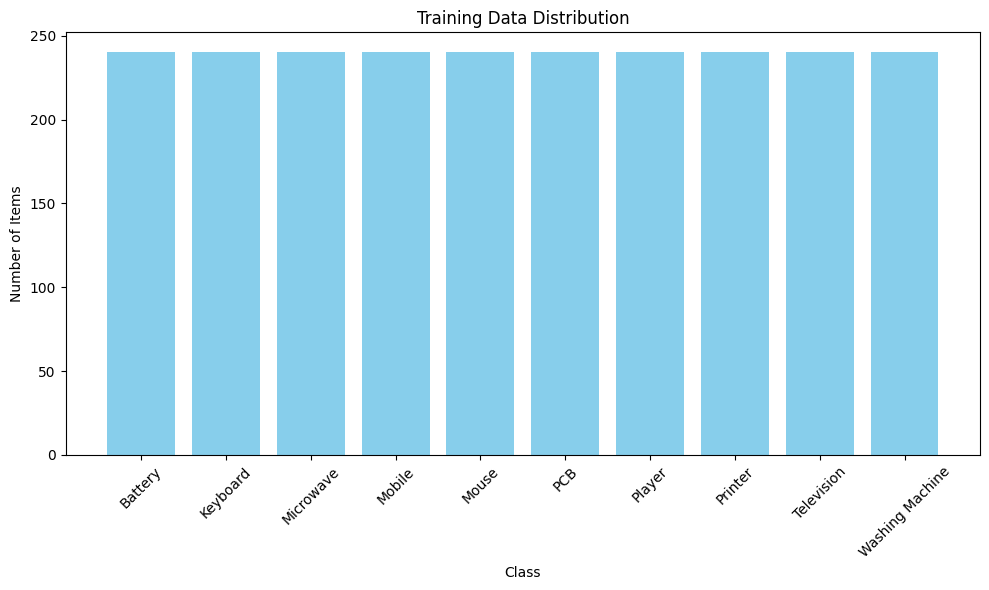

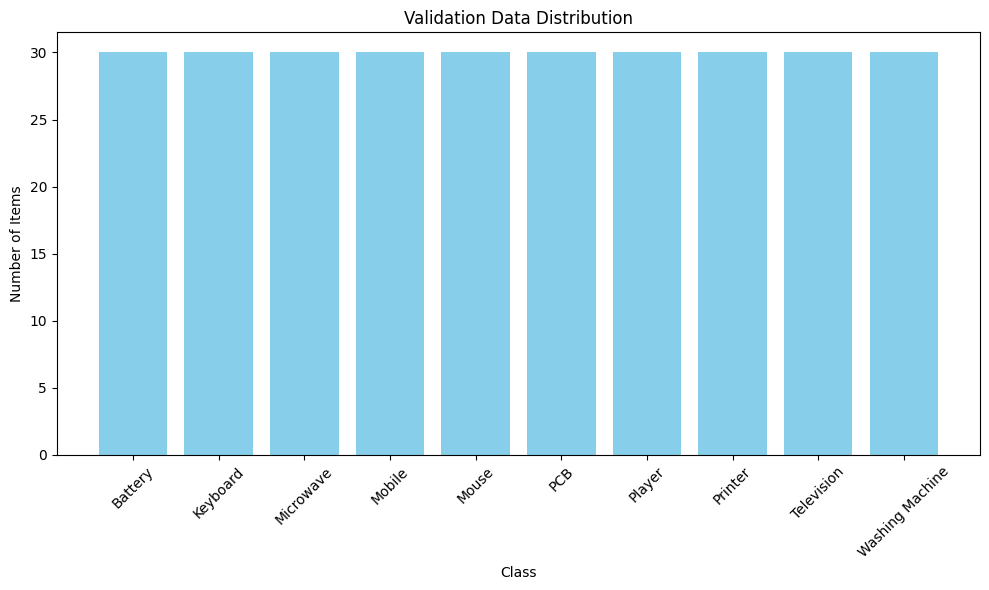

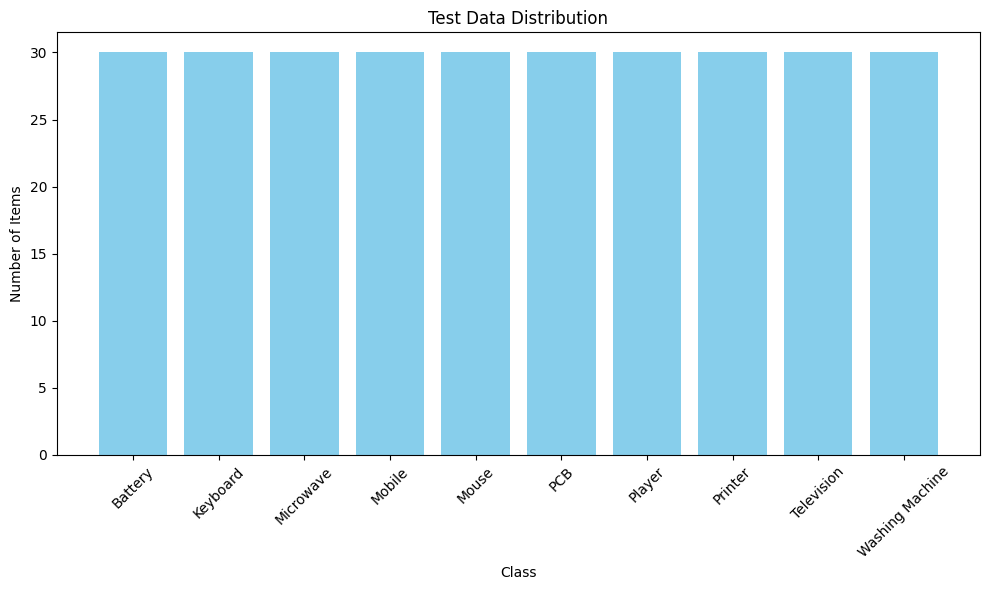

In [9]:
plot_class_distribution(train_ds, "Training Data Distribution")
plot_class_distribution(val_ds, "Validation Data Distribution")
plot_class_distribution(test_ds, "Test Data Distribution")

## 3. Model Architecture

We define a model architecture that combines a pre-trained convolutional neural network (EfficientNetV2B0) for image feature extraction with a simple neural network for processing metadata. The features from both branches are then concatenated and passed through a few dense layers for the final classification.

In [10]:
image_input = Input(shape=(128, 128, 3), name="image_input")
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False, weights='imagenet', input_tensor=image_input
)
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)


meta_input = Input(shape=(4,), name="metadata_input")
m = layers.Dense(64, activation='relu')(meta_input)
m = layers.Dropout(0.2)(m)


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
fused = layers.Concatenate()([x, m])
fused = layers.Dense(64, activation='relu')(fused)
fused = layers.Dropout(0.3)(fused)
output = layers.Dense(10, activation='softmax')(fused)


model = Model(inputs=[image_input, meta_input], outputs=output)

## 4. Model Training

We compile the model and train it on the prepared training data, using the validation data to monitor performance and prevent overfitting.

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    [X_train, train_meta], y_train,
    validation_data=([X_val, val_meta], y_val),
    epochs=10,
    batch_size=32
)



Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 669ms/step - accuracy: 0.2734 - loss: 3.7040 - val_accuracy: 0.9033 - val_loss: 0.7876
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 607ms/step - accuracy: 0.7241 - loss: 0.9747 - val_accuracy: 0.9267 - val_loss: 0.2770
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 80s 580ms/step - accuracy: 0.8406 - loss: 0.5194 - val_accuracy: 0.9200 - val_loss: 0.2245
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 673ms/step - accuracy: 0.8738 - loss: 0.4276 - val_accuracy: 0.9167 - val_loss: 0.2290
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 572ms/step - accuracy: 0.9063 - loss: 0.3090 - val_accuracy: 0.9500 - val_loss: 0.1770
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 590ms/step - accuracy: 0.9315 - loss: 0.2180 - val_accuracy: 0.9567 - val_loss: 0.1686
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 678ms/step - accuracy: 0.9349 - loss: 0.2198 - val_accuracy: 0.9533 - val_loss: 0.1567
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 75s 589ms/step - accuracy: 0.9345 - loss: 0.2083 - val_accu

In [13]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ image_input[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 32, 32,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 32, 32,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 32, 32,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 32, 32,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 32, 32,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

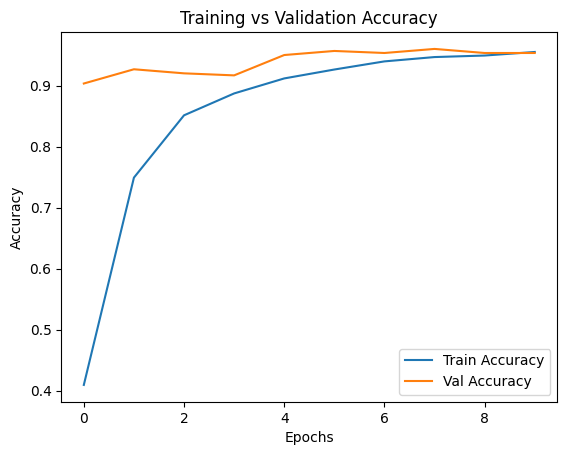

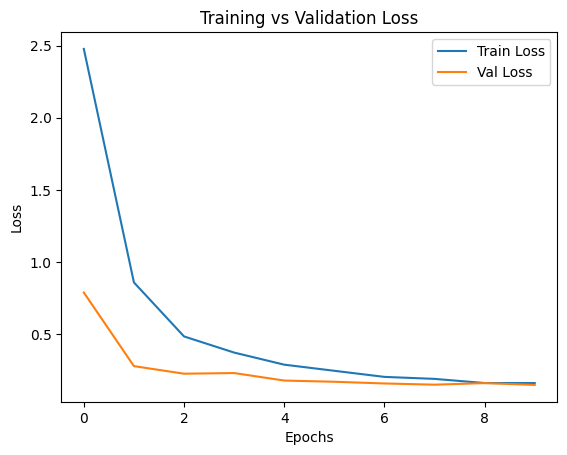

In [14]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

## 5. Evaluation

After training, we evaluate the model's performance on the unseen test set to get an estimate of its generalization ability.

In [15]:
test_loss, test_acc = model.evaluate([X_test, test_meta], y_test)
print("Test Accuracy:", test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 565ms/step - accuracy: 0.9396 - loss: 0.1809
Test Accuracy: 0.949999988079071


In [16]:
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    return np.expand_dims(img, axis=0)

def predict(image, weight, voltage, is_portable, material_score):
    image = preprocess_image(image)
    metadata = np.array([[weight, voltage, is_portable, material_score]])
    prediction = model.predict([image, metadata])[0]

    class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']
    index = np.argmax(prediction)
    confidence = prediction[index]

    return f"Predicted: {class_names[index]} (Confidence: {confidence:.2f})"



## 6. Creating an Interactive Demo

Finally, we use Gradio to create a simple web-based interface for our model, allowing users to upload an image and provide metadata to get a real-time prediction.

In [17]:
interface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Image(type="numpy", label="E-Waste Image"),
        gr.Slider(0.1, 5.0, step=0.1, label="Weight (kg)"),
        gr.Slider(1.5, 220.0, step=1.0, label="Voltage"),
        gr.Radio([0, 1], label="Is Portable? (0 = No, 1 = Yes)"),
        gr.Slider(0.0, 1.0, step=0.01, label="Material Score")
    ],
    outputs=gr.Label(num_top_classes=3),
    title="E-Waste Image + Metadata Classifier"
)

interface.launch(debug=False)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a75e543676a6ce7d30.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
